## GAN
Generative adversarial network (GAN) is a powerful deep generative model. It is capable of synthesising realistic images. For example, DeepFake uses GAN to swap faces in the video. 
![img](gan.png)

There is a competition going on in the GAN. There is a discriminator that tries to tell the fake image from the real image. There is also a generator that generates fake images and tries to fool the discriminator. The competition between the two encourages both of them to improve. At the end, we have a good generator that is able to generate realistic images.


### Install a facial landmark package for the first time

In [1]:
!pip install face-alignment

  Using cached https://files.pythonhosted.org/packages/20/86/26baa3888c254c9ce284702a1041cf9a533ad91c873b06f74d3cfa23aff7/face_alignment-1.0.0-py2.py3-none-any.whl
     |████████████████████████████████| 43.7MB 23kB/s  eta 0:00:01                               | 829kB 1.8MB/s eta 0:00:24     |█▎                              | 1.7MB 1.8MB/s eta 0:00:23     |████▉                           | 6.6MB 4.8MB/s eta 0:00:08     |████████▌                       | 11.6MB 5.7MB/s eta 0:00:06     |███████████                     | 15.1MB 5.7MB/s eta 0:00:06     |████████████▋                   | 17.3MB 5.2MB/s eta 0:00:06     |██████████████████████████████▋ | 41.8MB 5.3MB/s eta 0:00:01
     |████████████████████████████████| 11.5MB 139kB/s eta 0:00:01    |████████████████                | 5.8MB 5.1MB/s eta 0:00:02
ERROR: matplotlib 3.3.0 has requirement pillow>=6.2.0, but you'll have pillow 5.3.0 which is incompatible.
  Found existing installation: matplotlib 3.0.0
    Uninstalling matplotlib-3.0

### Import packages

In [2]:
from skimage.io import imsave
import torch
from torchvision.transforms import Compose, Resize, CenterCrop
import numpy as np
from PIL import Image
import face_alignment
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from models import *
import cv2
import pdb
import glob
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

Matplotlib is building the font cache; this may take a moment.


### define helper functions

In [46]:
def denorm(tensor):
    return ((tensor+1.0)/2.0)*255.0

def norm(image):
    return (image/255.0-0.5)*2.0

transforms = Compose([
                CenterCrop(135),
                Resize(128)
                ])

def get_z_random(batch, nz):
    z = torch.FloatTensor(batch, nz)
    z.copy_(torch.randn(batch, nz))
    return z 


### Load input image

In [47]:
img = Image.open('images/6.jpg').convert('RGB')
img = np.array(img)

### Import facial landmark algorithm

In [48]:
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False, device='cpu')
preds = fa.get_landmarks(img)

### Draw landmarks on face

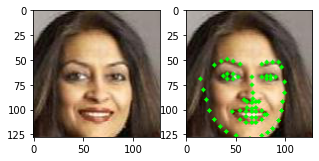

In [49]:
input_with_FL = img.copy()
for (x, y) in preds[0]:
   cv2.circle(input_with_FL, (x, y), 2, (0, 255, 0), -1)

plt.rcParams["figure.figsize"] = (5,3)
plt.subplot(1,2,1); plt.imshow(img)
plt.subplot(1,2,2); plt.imshow(input_with_FL)

### detect the bounding box around the face

In [50]:
pts = np.array(preds[0])
x_min = pts[:,0].min()
x_max = pts[:,0].max()
y_min = pts[:,1].min()
y_max = pts[:,1].max()

In [51]:
img.shape

(128, 128, 3)

In [52]:
# crop the face and resize it if larger than given size 128
if img.shape[0] > 128:
    img = Image.fromarray(img)
    y_extend = 2 / 3 * (y_max - y_min)
    img = img.crop((x_min-y_extend//2, y_min-y_extend, x_max+y_extend//2, y_max)).resize((128,128))
    img = np.array(img)
    plt.imshow(img)

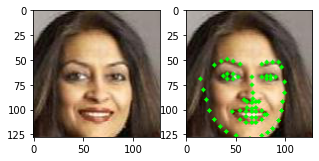

In [53]:
# detect landmarks again
preds = fa.get_landmarks(img)
input_with_FL = img.copy()
for (x, y) in preds[0]:
   cv2.circle(input_with_FL, (x, y), 2, (0, 255, 0), -1)

plt.rcParams["figure.figsize"] = (5,3)
plt.subplot(1,2,1); plt.imshow(img)
plt.subplot(1,2,2); plt.imshow(input_with_FL)

### crop the face using facial landmarks

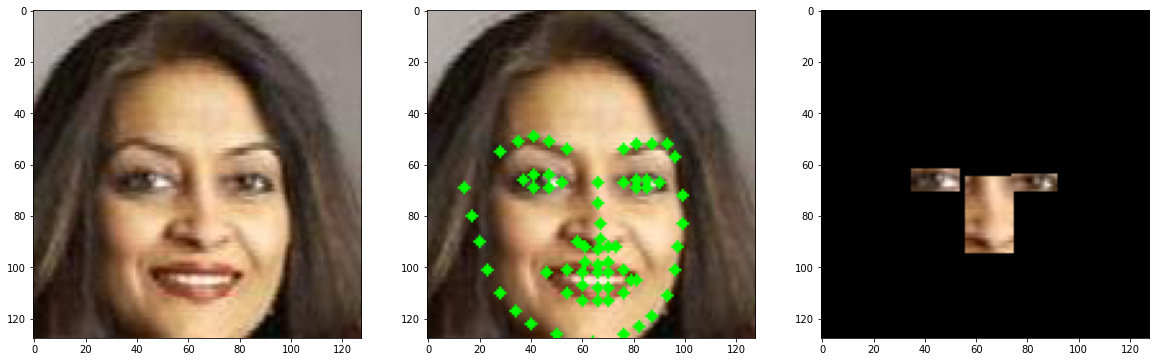

In [54]:
mask = np.zeros((img.shape[0], img.shape[1]))

############### left eye ####################
left_eye = preds[0][36:42]
n = 2
left_eye_mask = np.zeros((img.shape[0], img.shape[1]))
left_eye_mask[int(min(left_eye[:,1])-n):int(max(left_eye[:,1])+n), int(min(left_eye[:,0])-n):int(max(left_eye[:,0])+n)] = 1

############### right eye ####################
right_eye = preds[0][42:48]
n = 2
right_eye_mask = np.zeros((img.shape[0], img.shape[1]))
right_eye_mask[int(min(right_eye[:,1])-n):int(max(right_eye[:,1])+n), int(min(right_eye[:,0])-n):int(max(right_eye[:,0])+n)] = 1

############### nose ####################
nose = preds[0][27:36]
n = 2
nose_mask = np.zeros((img.shape[0], img.shape[1]))
nose_mask[int(min(nose[:,1])-n):int(max(nose[:,1])+n), int(min(nose[:,0])-n):int(max(nose[:,0])+n)] = 1

mask += left_eye_mask
mask += right_eye_mask
mask += nose_mask
mask[mask>0] = 1

crop_face = np.zeros((img.shape))
for i in range(3):
    crop_face[:,:,i] = img[:,:,i]*mask

plt.rcParams["figure.figsize"] = (20,10)
plt.subplot(1,3,1); plt.imshow(img)
plt.subplot(1,3,2); plt.imshow(input_with_FL)
plt.subplot(1,3,3); plt.imshow(crop_face/255)

### Hallucinate the whole face using GAN

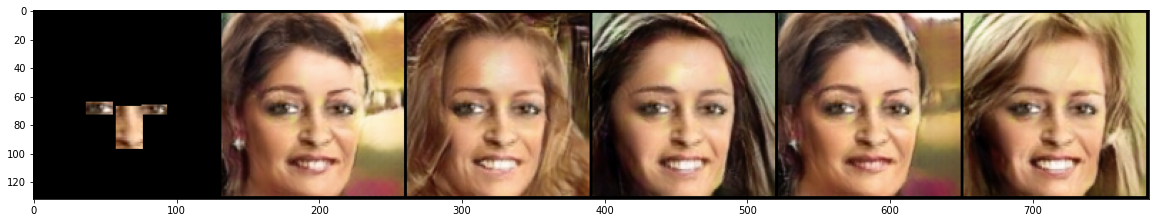

In [55]:
from models import Encoder, Decoder

encoder = torch.load('models/encoder_180000.pt', map_location=lambda storage, loc: storage)
decoder = torch.load('models/decoder_180000.pt', map_location=lambda storage, loc: storage)

grid_image = np.zeros((6,128,128,3))
grid_image[0] = crop_face
for f in range(5):
    crop_face_tensor = torch.from_numpy(crop_face).unsqueeze(0).transpose(1,3).transpose(2,3).float()
    crop_face_tensor = norm(crop_face_tensor)
    
    batch = crop_face_tensor.shape[0]
    code, feats = encoder(crop_face_tensor)
    nz = 16
    z = get_z_random(batch, nz)
    
    high_hat = decoder(torch.cat([code, z], dim=1).unsqueeze(2).unsqueeze(3), feats)
    high_hat_np = denorm(high_hat).transpose(1,3).transpose(1,2).squeeze(0).data.numpy()
    
    for i in range(3):
        high_hat_np[:,:,i] = (1-mask)*high_hat_np[:,:,i] + mask*crop_face[:,:,i]
    grid_image[f+1] = high_hat_np 

grid_image = torch.from_numpy(grid_image).transpose(1,3).transpose(2,3)
demo = make_grid(grid_image, nrow=6, padding=2, normalize=True)
demo_np = demo.transpose(0,2).transpose(0,1).numpy()

plt.rcParams["figure.figsize"] = (20,10)
plt.figure(); plt.imshow(demo_np)